In [130]:

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import pygraphviz
from pickle import load, dump
from collections import Counter
from tqdm import tqdm
from btk import Record

plt.style.use(f"{os.environ['style']}")

with open(r'D:\dstore\nlp\w2v\fwords', 'rt') as f:
    full_words = Counter({f'_{x[1]}_': int(x[0]) for x in [x.strip().split() for x in f.readlines()]})

for x in [x for x in full_words if len(x) < 5]:
    full_words.pop(x)
for x in [x for x in full_words if "'" in x]:
    out = x.split("'")
    if f'{out[0]}_' in full_words:
        full_words[f'{out[0]}_'] += full_words[x]
    full_words.pop(x)

ldct = {
    'alpha': {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"},
    'unifx': {'s_', 'd_', 'r_', 'n_', 't_', 'x_', 'y_', 'a_', 'i_', 'o_', '_a', '_o', '_e', '_i'},
    'unifx_l': {'s_', 'y_', '_a', '_e'},
    'fdbl': {'b', 'c', 'd', 'f', 'g', 'l', 'm', 'n', 'p', 'r', 's', 't'},
    'bdbl': {'b', 'd', 'g', 'm', 'l', 'n', 'p', 'r', 't'},
    'avwls': {'a', 'e', 'i', 'o', 'u', 'y'},
    'bvwls': {'a', 'e', 'i', 'o', 'u'},
    'cvwls': {'a', 'e', 'o', 'i', 'y'},
    'dvwls': {'a', 'e', 'o', 'u'},
    'fvwls': {'a', 'o', 'i', 'u'},
    'uafxs': {'logy_', 'ity_', 'try_', 'cy_', 's_', 'y_'}
}

def get_nested(subject, stage, src):
    hln = len(subject) * 3
    hold = {x for x in src if subject in x and len(x) < hln}
    if subject.strip('_') in hold:
        hold.remove(subject.strip('_'))
    return hold

def extract_afx(subject, group, stage, src) -> list:
    if stage == 1:
        hold = []
        group = [f'_{x}_'.split(subject) for x in group]
        for x in group:
            for y in x:
                if len(y) > 2 or y in singles:
                    hold.append(y)
    return hold

def afx_count(inp: Counter, stage: int):
    hold = dict()
    nons = []
    if stage == 1:
        src = inp
    else:
        src = {x.strip('_') for x in inp}
    for subject in tqdm(inp):
        out = get_nested(subject, stage, src)
        if out:
            hold[subject] = out
        else:
            nons.append(subject)
    outp = Counter()
    for subject in hold:
        out = extract_afx(subject, hold[subject], stage, inp)
        if out:
            for x in out:
                outp[x] += 1
    return (Counter({x[0]: x[1] for x in outp.most_common() if x[1] > 2}), nons)

def search(term, corpus, exc=None):
    if not exc:
        return sorted({x for x in corpus if term in x})
    elif isinstance(exc, str):
        return sorted({x for x in corpus if term in x and exc not in x})
    else:
        return sorted({x for x in corpus if term in x and all(y not in x for y in exc)})

def gsub(target: str, afx: str, best=True, amode=0, guard=True, dbg=False):
    if amode == 0:
        if len(target) - len(afx) < 4: return
    else:
        if len(target) - len(afx) < 2: return
    rep = target.replace(afx, '')
    candidates = [target.replace(afx, '_')]
    if afx[0] == '_':
        pre = True
    else:
        pre = False
    if not pre or amode in (1, 2):
        if afx in ldct['uafxs']:

            if afx == 'logy_':
                candidates.append(f'{rep}a_')
                candidates.append(f'{rep}l_')
                candidates.append(f'{rep[:-1]}_')
                candidates.append(f'{rep[:-2]}_')
            elif afx == 'ity_':
                if rep.endswith('abil'):
                    candidates.append(rep.replace('abil', 'able_'))
                if rep.endswith('ibil'):
                    candidates.append(rep.replace('ibil', 'ible_'))
            elif afx == 'try_':
                candidates.append(f'{rep}t_')
            elif afx == 'cy_':
                candidates.append(f'{rep}t_')
                if rep[-1] == 'a': 
                    candidates.append(f'{rep}te_')
            elif afx == 's_':
                if rep[-1] in ['s', 'i', 'u']: return
            elif afx == 'y_':
                if rep[-1] in ldct['bvwls']: return

        if dbg: print(candidates)
        if afx[0] in ldct['bvwls']:
            if afx[0] == rep[-1]:
                return
            dreps = [rep]
            if len(rep) > 4 and rep[-1] == rep[-2] and rep[-1] in ldct['bdbl']:
                dreps.append(rep[:-1])
                candidates.append(f'{rep[:-1]}_')
            elif rep[-1] in ldct['fvwls']:
                candidates.append(f'{rep[:-1]}_')
                candidates.append(f'{rep[:-1]}e_')
                if rep[-1] == 'i':
                    candidates.append(f'{rep[:-1]}y_')
            for drep in dreps:
                candidates.append(f'{drep}e_')
                candidates.append(f'{drep}a_')
                candidates.append(f'{drep}y_')
                if afx[0] == 'e':
                    if drep[-1] == 'v':
                        candidates.append(f'{drep[:-1]}f_')
                    if drep[-1] == 'm':
                        candidates.append(f'{drep[:-1]}_')
                elif afx[0] == 'i':
                    if drep[-1] == 't':
                        candidates.append(f'{drep[:-2]}e_')
                        candidates.append(f'{drep[:-2]}_')
                        if drep[-2] == 'i':
                            candidates.append(f'{drep[:-1]}sh_')
                        elif drep.endswith('ipt'):
                            candidates.append(f'{drep[:-2]}be_')
                        elif drep.endswith('orpt'):
                            candidates.append(f'{drep[:-2]}b_')
                    elif drep[-1] == 's':
                        candidates.append(f'{drep[:-1]}e_')
                        if drep[-2] in ldct['avwls']:
                            candidates.append(f'{drep[:-1]}de_')
                            candidates.append(f'{drep[:-1]}re_')
                        elif drep[-2] == 's' and len(drep) > 2:
                            if drep[-3] in ldct['dvwls']:
                                candidates.append(f'{drep[:-2]}de_')
                            elif drep[-3] == 'i':
                                candidates.append(f'{drep[:-2]}t_')
                        elif drep[-2] == 'r':
                            candidates.append(f'{drep[:-1]}t_')
                        elif drep[-2] == 'n':
                            candidates.append(f'{drep[:-1]}d_')
                elif afx[0] == 'a':
                    if drep.endswith('ti'):
                        candidates.append(f'{drep[:-2]}ce_')

    if dbg: print(candidates)
    if amode == 0: 
        out = sorted([(x, full_words[x]) for x in candidates if (x in full_words and full_words[x] > 4)], key=lambda x: x[1])
    elif amode == 1:
        out = sorted([(x, tf2[x]) for x in candidates if x in tf2], key=lambda x: x[1])
    else:
        out = []
        if pre:
            for x in candidates:
                mafx = f'{x[1:]}_'
                full = f'{x}_'
                if mafx in tf2 and tf2[mafx] > 8:
                    out.append((mafx, tf2[mafx]))
                elif full in full_words and full_words[full] > 256:
                    out.append((full, np.log2(full_words[full])))
        else:
            for x in candidates:
                mafx = f'_{x[:-1]}'
                full = f'_{x}'
                if mafx in tf2 and tf2[mafx] > 8:
                    out.append((mafx, tf2[mafx]))
                elif full in full_words and full_words[full] > 256:
                    out.append((full, np.log2(full_words[full])))
        out = sorted(out, key=lambda x: x[1])
    if out:
        if best: return out[-1][0]
        else: return out

def compress(oafx, dbg=False, t=full_words):
    cnt = Counter()
    if oafx[0] == '_': pre = True
    else: pre = False
    if len(oafx) == 1:
        for x in [x for x in t if x[0] == '_']:
            cnt[x[1]] += 1
        for x in [x for x in t if x[-1] == '_']:
            cnt[x[-2]] += 1
    else:
        afx = oafx.strip('_')
        full_group = [x.split(afx) for x in t if afx in x]
        prefixes = [x[0] for x in full_group]
        suffixes = [x[1] for x in full_group]
        if dbg: print(prefixes)
        if dbg: print(suffixes)
        if pre:
            for x in suffixes:
                if x:
                    cnt[x[0]] += 1
        else:
            for x in prefixes:
                if x:
                    cnt[x[-1]] += 1
        if '_' in cnt:
            cnt.pop('_')
    cnt = Counter({x[0]: x[1] for x in cnt.items() if x[1] > 1})
    return cnt

def target_removal(afx, exc1=None, exc2=None, exe=False, dbg=False):
    if exc1 and exc2:
        if isinstance(exc1, str) and isinstance(exc2, str):
            targets = [x for x in tf2 if afx in x and x not in (afx, exc1) and exc2 not in x]
        elif isinstance(exc1, str):
            targets = [x for x in tf2 if afx in x and x not in (afx, exc1) and all(y not in x for y in exc2)]
        elif isinstance(exc2, str):
            targets = [x for x in tf2 if afx in x and x not in (afx, exc1) and exc2 not in x]
        else:
            targets = [x for x in tf2 if afx in x and x not in (afx, *exc1) and all(y not in x for y in exc2)]
    elif exc1:
        if isinstance(exc1, str):
            targets = [x for x in tf2 if afx in x and x not in (afx, exc1)]
        else:
            targets = [x for x in tf2 if afx in x and x not in (afx, *exc1)]
    elif exc2:
        if isinstance(exc2, str):
            targets = [x for x in tf2 if afx in x and x != afx and exc2 not in x]
        else:
            targets = [x for x in tf2 if afx in x and x != afx and all(y not in x for y in exc2)]
    else:
        targets = [x for x in tf2 if afx in x and x != afx]
    rem = []
    if dbg: print(targets)
    for x in targets:
        tmp = gsub(x, afx, amode=1)
        if tmp:
            rem.append((x, tmp))
    if exe:
        for x in rem:
            tf2[x[1]] += tf2[x[0]]
            tf2.pop(x[0])
    else:
        return rem

def pulld(afx, len_lim=False):
    aln = len(afx)
    sub_set = [x for x in tf2 if afx in x]
    out = []
    for x in sub_set:
        i = 1
        if x[0] == '_':
            while len(x[:-i]) > aln:
                if x[:-i] in sub_set:
                    break
                i += 1
            else:
                out.append(x)
        else:
            while len(x[i:]) > aln:
                if x[i:] in sub_set:
                    break
                i += 1
            else:
                out.append(x)
    if len_lim:
        return [x for x in out if x != afx]
    else:
        return [x for x in out if len(x) == len(afx)+1 and x != afx]

def pullu(afx):
    i = 1
    if afx[0] == '_':
        while i < len(afx):
            if afx[:-i] in tf2:
                return afx[:-i]
            i += 1
    else:
        while i < len(afx):
            if afx[i:] in tf2:
                return afx[i:]
            i += 1

""" with open(r'D:\dstore\tmp\3', 'rb') as f:
    tf2 = load(f) """
with open(r'D:\dstore\tmp\2', 'rb') as f:
    pfx1, sfx1 = load(f)
with open(r'D:\dstore\tmp\4', 'rb') as f:
    ndst, pdst, sdst = load(f)
with open(r'D:\dstore\tmp\7', 'rb') as f:
    tf2, rntp, drntp = load(f)
with open(r'D:\dstore\tmp\8', 'rb') as f:
    frel, brel, dfrel, dbrel = load(f)


In [134]:
tf2['_'] = 30000
renta = [x for x in renta]
renta.append(np.array([[0.05] * 3] * 4))
renta = np.array(renta)
rcodex['_'] = 12519
end_avg = np.array([renta[rcodex[y]] for y in [x for x in tf2 if all(x not in y for y in tf2 if y != x)]]).mean(axis=0)

drenta = {'_': np.array([[0] * 3] * 4)}
for x in [x for x in tf2 if x != '_']:
    above = pulld(x)
    if above:
        above = np.array([renta[rcodex[y]] for y in above]).mean(axis=0)
    else:
        above = end_avg
    below = renta[rcodex[pullu(x)]]
    middle = renta[rcodex[x]]
    drenta[x] = (above-middle) - (middle-below)

dend_avg = np.array([drenta[y] for y in [x for x in tf2 if all(x not in y for y in tf2 if y != x)]]).mean(axis=0)

array([[-0.18440226, -0.15515307, -0.07800163],
       [-0.18734634, -0.1428254 , -0.04365283],
       [-0.15627919, -0.11582204, -0.04008019]])

In [28]:
test = sorted([x for x in tf2 if (x in 'ionalization_' or 'ionalization_' in x) and x != '_'], key=lambda x: len(x), reverse=True)

In [29]:
rmlst = []
for x in test:
    if x[0] == '_':
        idxs = [0, 2, 3]
    else:
        idxs = [0, 1, 3]
    high = pulld(x)
    if high:
        high = np.array([drenta[y] for y in pulld(x)]).mean(axis=0)
    else:
        high = dend_avg
    low = drenta[pullu(x)]
    mid = drenta[x]
    if len([x for x in mid[mid < low] if x in mid[mid < high]]) < 5:
        rmlst.append(x)


In [139]:
renta[rcodex['_supra']]

array([[0.69213458, 0.69213458, 0.71354293],
       [0.91096706, 0.91096706, 0.91096706],
       [0.88245588, 0.88245588, 0.89392357],
       [0.75864445, 0.75864445, 0.80336519]])

In [136]:
dscrm['_supra']

array([-0.13918565, -0.12460819, -0.10406047, -0.17600926, -0.1379335 ,
       -0.05391155])

In [138]:
[*[np.mean(x) for x in pdend], *[np.mean(x) for x in pdend.T]]

[-0.13918565175842532,
 -0.12460819043820613,
 -0.10406047279250458,
 -0.1760092624699926,
 -0.13793350329579412,
 -0.05391154922334931]

In [135]:
for x in tf2:
    if not pulld(x, True):
        print(x)

back_
_ortho
head_
sman_
book_
houses_
_cyto
ball_
lands_
boards_
smen_
stone_
maker_
_high
making_
time_
_kilo
_supra
_bull
bird_
down_
fulness_
box_
_base
master_
_rail
_pyro
_hair
_cow
_blood
_code
lessly_
water_
makers_
books_
wood_
heads_
set_
_penta
backs_
_hexa
works_
_turbo
_cut
yard_
_ring
_morpho
aged_
ette_
lings_
_rock
rooms_
_face
_shop
point_
_with
stones_
ently_
_honey
aging_
holder_
holders_
_care
_wave
erly_
_pharmaco
_door
_ice
birds_
off_
_dog
_nucleo
_finger
ency_
_shoe
_overw
weight_
cast_
liness_
ually_
_hot
grass_
_peace
_safe
_watch
band_
_net
fly_
_plat
boat_
_anthropo
_cup
overs_
_unen
_ideo
_hind
_case
_metro
_cheese
_phyto
_king
_phono
piece_
yards_
_stream
eri_
_tree
keeper_
_farm
_dead
_gate
boats_
_homeo
_holo
by_
points_
worm_
_chrono
wards_
goers_
wort_
play_
_half
bill_
ifies_
field_
fold_
_pedi
_steel
dom_
_boat
_cosmo
ionary_
_sero
plate_
_score
_skate
_tres
_horse
shot_
pods_
antly_
downs_
_saw
body_
hand_
flies_
ah_
base_
front_
_club
_switch
ching

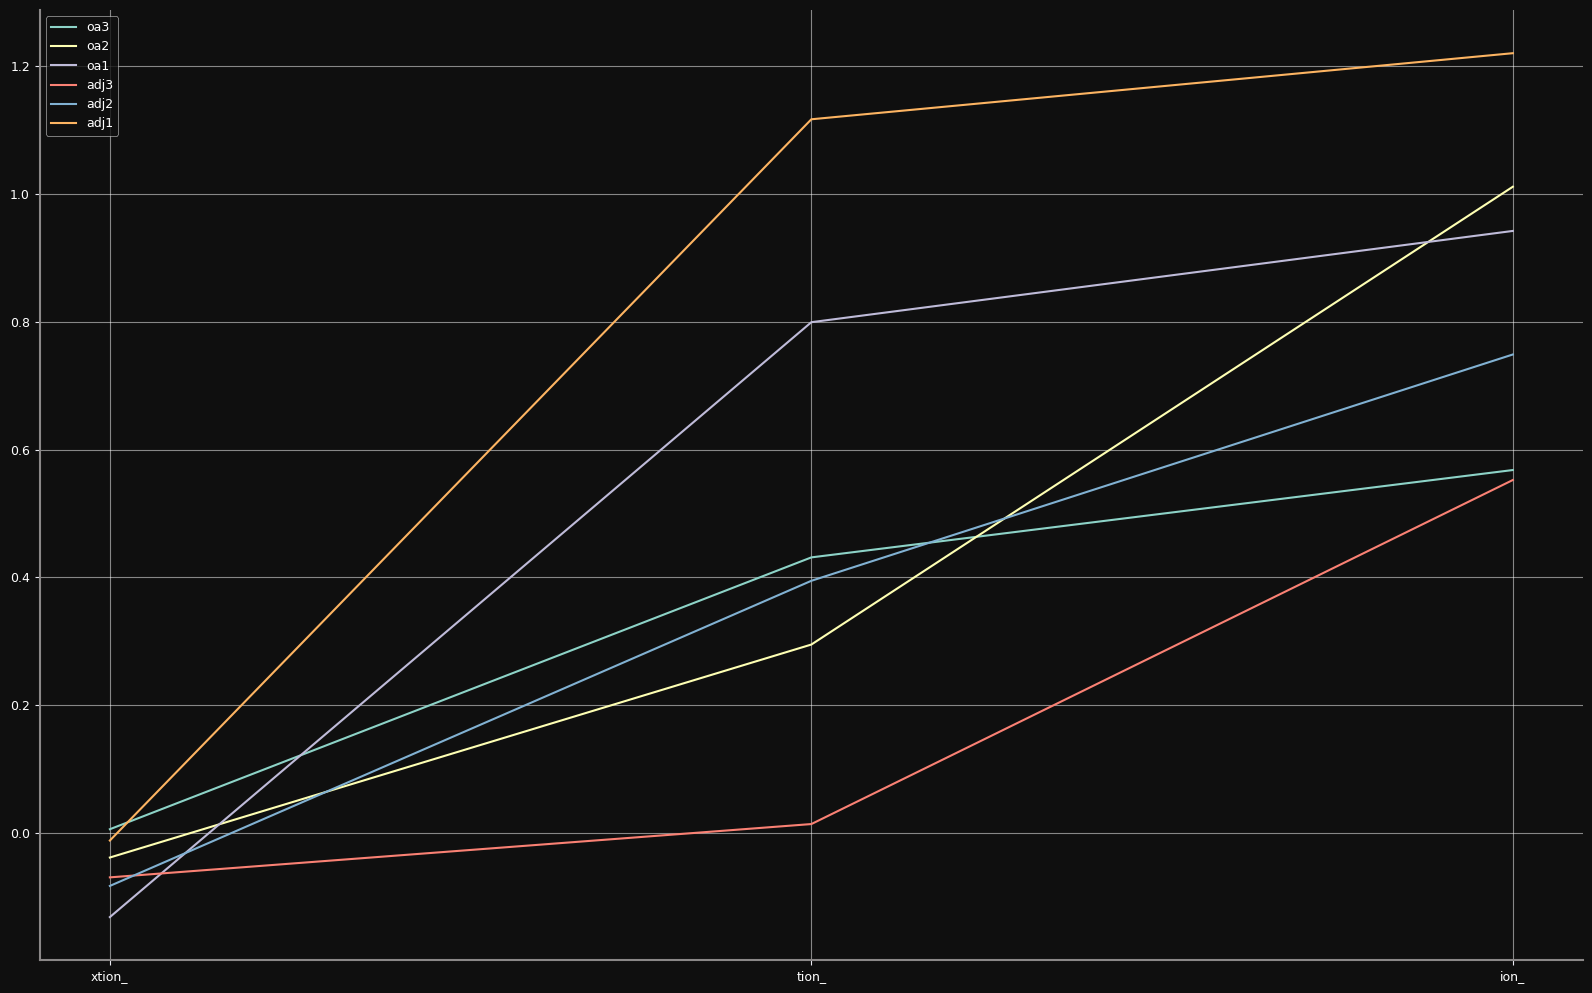

In [131]:
afx = 'tion_'
fig, ax = plt.subplots(figsize=(16, 10))
if afx[0] == '_':
    did = 1
    end = pdend
else:
    did = 2
    end = sdend

high = [dscrm[y] for y in pulld(afx, True)]
if not high:
    high = end
else:
    high = np.mean(high, axis=0)

mid = dscrm[afx]
low = dscrm[pullu(afx)]

yvars = [high, mid, low]

plt.xticks(range(len(yvars)), ['xtion_', 'tion_', 'ion_'])
ax.plot(range(len(yvars)), yvars)
ax.legend(['oa3', 'oa2', 'oa1', 'adj3', 'adj2', 'adj1', 'eadj3', 'eadj2', 'eadj1', 'dg1T', 'dg2T', 'dg3T'])

ionalization_ [-0.037905489726320574, -0.054555018220712105, -0.003522592625874584, 0.06029229007357739, -0.0468178105464625, -0.10945758010002216]
nalization_ [-0.2683028885124039, -0.1583446912029662, -0.19179449462646447, -0.29294161785192896, -0.20048041340214073, -0.1250200430877649]
alization_ [0.7386781948158521, 0.7198512033656591, 0.7460628510235998, 0.6051150106837303, 0.7519845756185214, 0.8474926629028593]
lization_ [-0.34483605583043886, -0.2951082428513631, -0.3717132115833855, -0.2144589576342015, -0.4696827420971914, -0.3275158105337946]
ization_ [0.6487718795496739, 0.7478863159939774, 0.6137680925224038, 0.4813993256156513, 0.856309577768228, 0.6727173846821756]
zation_ [-1.8512793957222737, -2.152046689790349, -1.5161923731080005, -1.2760633608686691, -2.049157115664622, -2.194297982087332]
ation_ [0.5927381106308246, 0.43684323673278697, 0.8622472695038838, 0.3950233923970165, 0.8270057189572589, 0.66979950551322]
tion_ [-0.12087108586309818, 0.500598144207076, -0.3

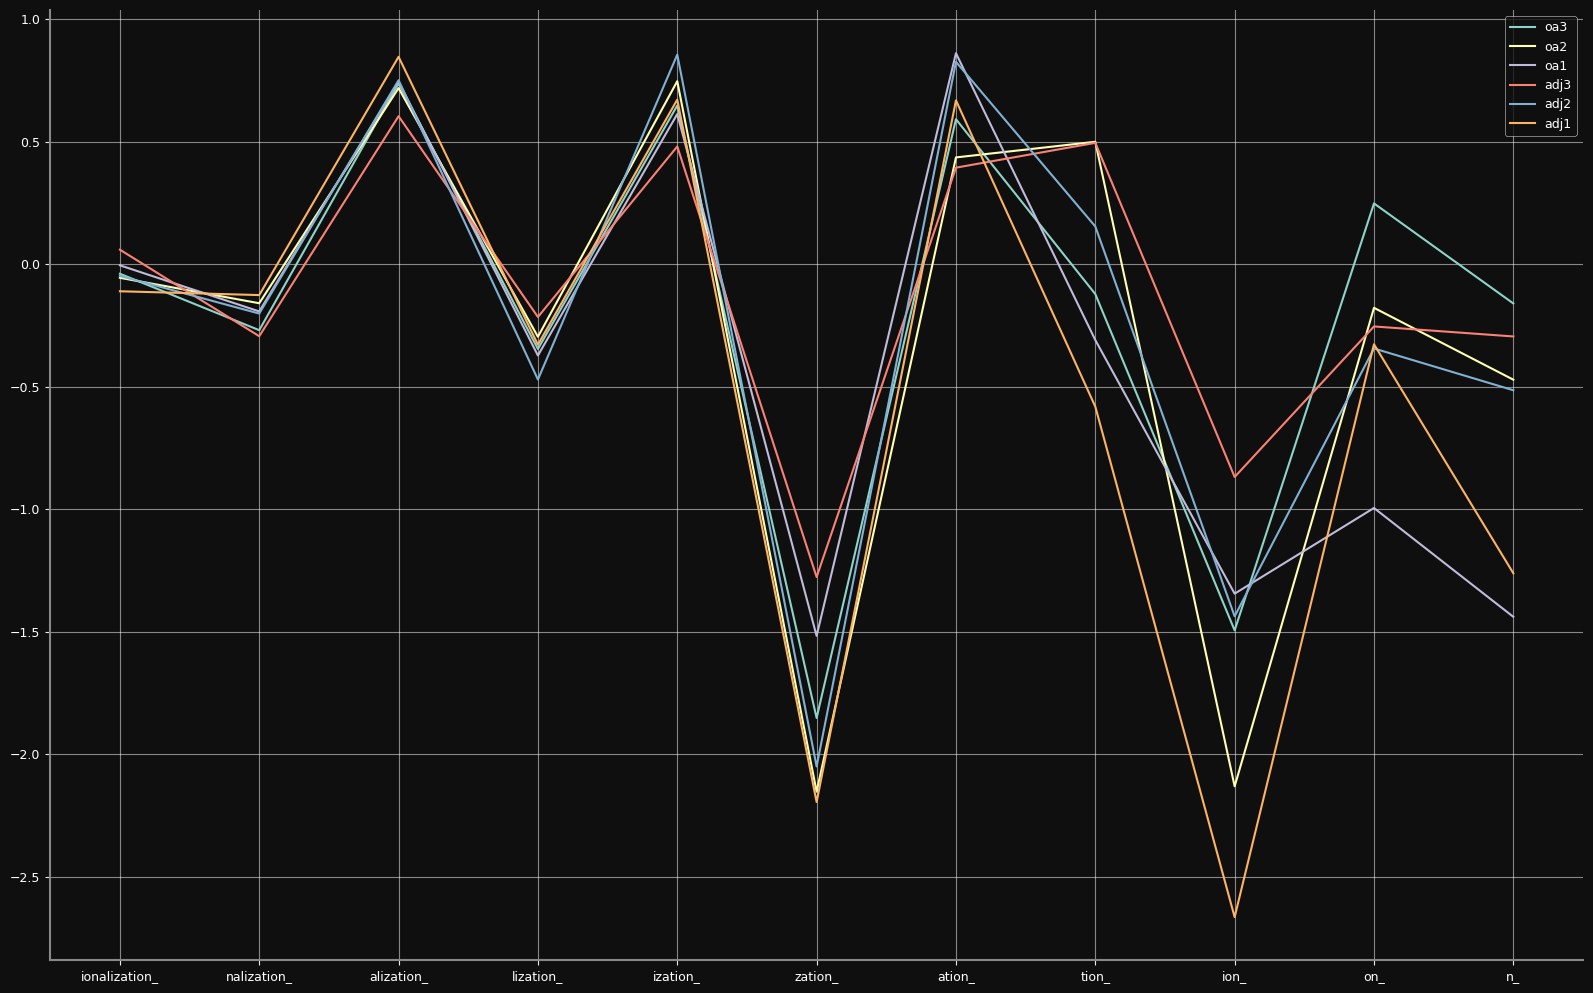

In [82]:
afx = 'ionalization_'
test = sorted([x for x in tf2 if x in afx and x != '_'], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
if afx[0] == '_':
    did = 1
    end = pdend
else:
    did = 2
    end = sdend

yvars = []
for x in test:
    dmat = np.delete(np.array(drenta[x]), did, axis=0)
    yvars.append([*[np.mean(y) for y in dmat], *[np.mean(y) for y in dmat.T]])
    print(x, [*[np.mean(y) for y in dmat], *[np.mean(y) for y in dmat.T]])

plt.xticks(range(len(yvars)), test)
ax.plot(range(len(yvars)), yvars)
ax.legend(['oa3', 'oa2', 'oa1', 'adj3', 'adj2', 'adj1', 'eadj3', 'eadj2', 'eadj1', 'dg1T', 'dg2T', 'dg3T'])

ionalization_ [-0.13918565175842532, -0.12041536729720281, -0.10406047279250458, -0.17247094561829837, -0.1367343851971909, -0.054456161032643426]
nalization_ [-0.037905489726320574, -0.054555018220712105, -0.003522592625874584, 0.06029229007357739, -0.0468178105464625, -0.10945758010002216]
alization_ [-0.2330724733137206, -0.16284177829069352, -0.2376173525865866, -0.20806119540076554, -0.21163080357957567, -0.21383960521065956]
lization_ [0.35159182611601025, 0.41391282978395766, 0.23059075148120126, 0.21165252327220987, 0.3347601129515252, 0.44968277115743405]
ization_ [0.24918833420303174, 0.3526292319819704, 0.19949816179409918, 0.16897623253583535, 0.16267327100010212, 0.4696662244431638]
zation_ [0.6487718795496739, 0.7478863159939774, 0.6137680925224038, 0.4813993256156513, 0.856309577768228, 0.6727173846821756]
ation_ [-0.07568979092364056, -0.06481524379048988, -0.04585505056320791, -0.075503923867298, -0.22042881701912975, 0.10957265560908941]
tion_ [0.43138527058216575, 0.

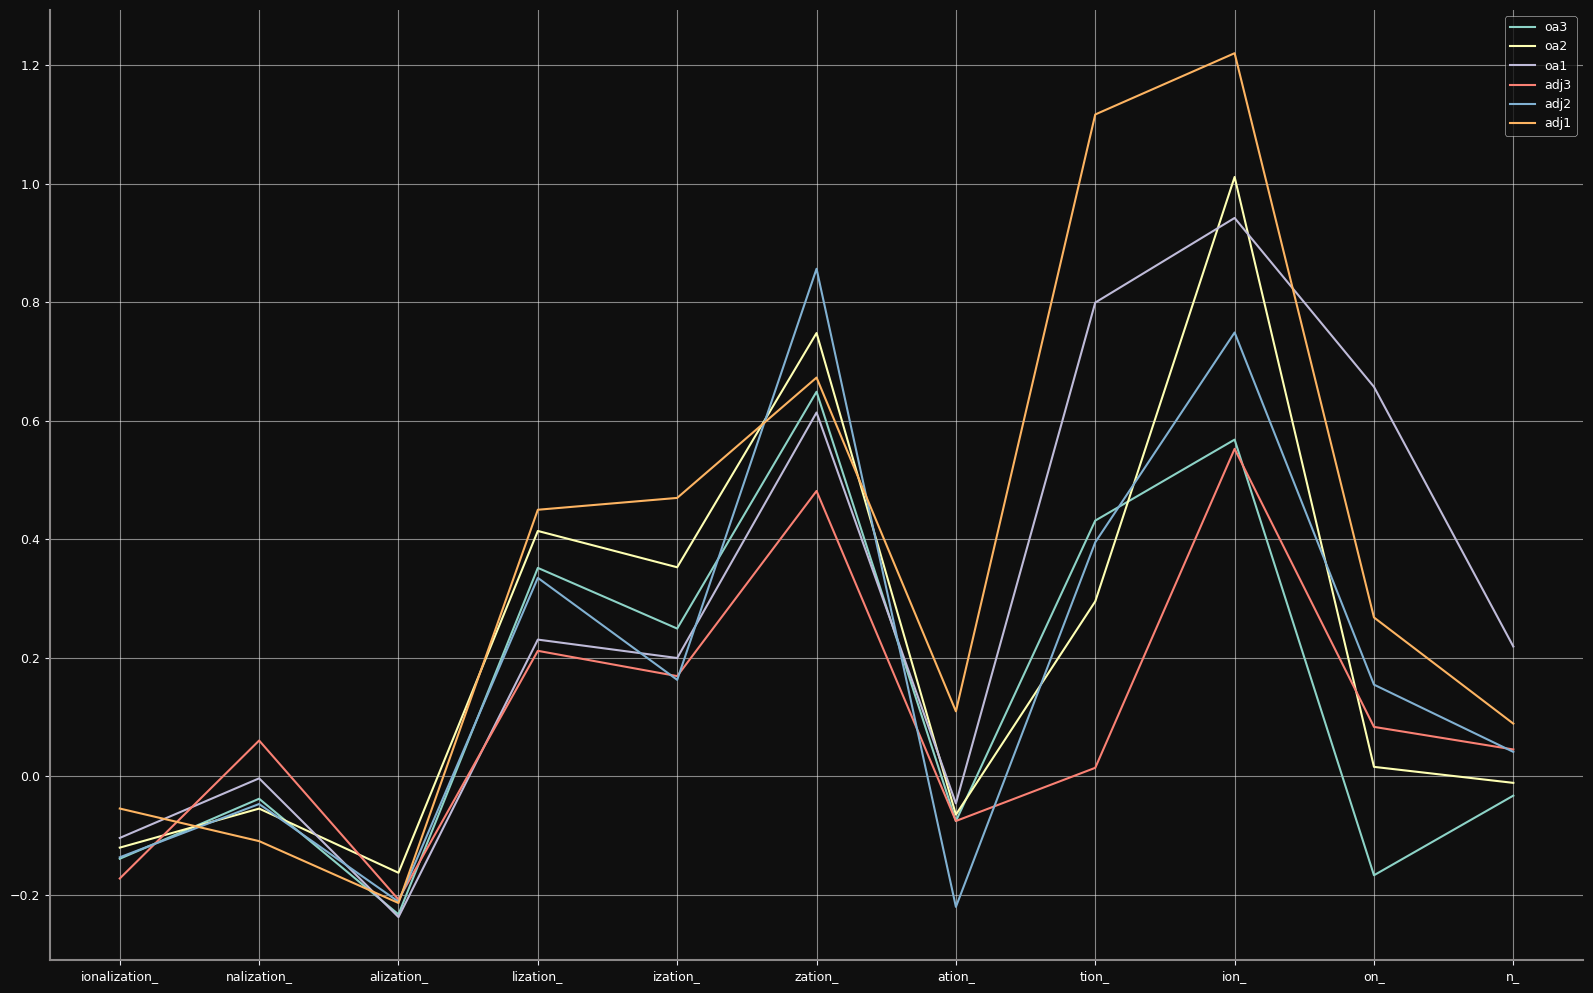

In [133]:
afx = 'ionalization_'
test = sorted([x for x in tf2 if x in afx and x != '_'], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
if afx[0] == '_':
    did = 1
    end = pdend
else:
    did = 2
    end = sdend

yvars = []
for x in test:
    dmat = [drenta[y] for y in pulld(x, True)]
    if not dmat:
        dmat = end
    else:
        dmat = np.delete(np.array(dmat).mean(axis=0), did, axis=0)
    yvars.append([*[np.mean(y) for y in dmat], *[np.mean(y) for y in dmat.T]])
    print(x, [*[np.mean(y) for y in dmat], *[np.mean(y) for y in dmat.T]])

plt.xticks(range(len(yvars)), test)
ax.plot(range(len(yvars)), yvars)
ax.legend(['oa3', 'oa2', 'oa1', 'adj3', 'adj2', 'adj1', 'eadj3', 'eadj2', 'eadj1', 'dg1T', 'dg2T', 'dg3T'])

In [105]:
dscrm['ption_']

array([-0.07380839, -0.1730124 ,  0.07320979,  0.12026481, -0.03424783,
       -0.25962798])

In [ ]:
larger = {x[0] for x in tf2.most_common() if len(x[0]) in (4, 5)}
for x in [x[0] for x in tf2.most_common() if len(x[0]) < 4 and len(x[0]) > 2]:
    for y in larger:
        if x in y:
            if tf2[y]*10 > tf2[x]:
                print(x, y, tf2[x], tf2[y])

In [34]:
#Start at root and iterate upwards until all things are gone
#Make function that pulls the next level down
    #Iterate through all items in pulled down level run eval algo
    #Must take parent affixes stats
    #If it doesnt pass then add to remove list
        #Else return to list

def word_check(fails):
    good = []
    bad = []
    for x in fails:
        if x[0] == '_':
            y = f'{x}_'
        else:
            y = f'_{x}'
        if y in full_words:
            good.append(y)
        bad.append(x)
    return good, bad

def scan(inp):
    fail = set()
    for x in tqdm(tf2):
        if x not in fail:
            out = compress(x, t=tf2)
            if not out:
                fail.add(x)
            elif len(out) == 1:
                sub = [x]
                c = 0
                new = x
                while len(out) == 1:
                    if x[0] == '_':
                        new = f'{new}{out.popitem()[0]}'
                    else:
                        new = f'{out.popitem()[0]}{new}'
                    if new in tf2:
                        sub.append(new)
                    out = compress(new)
                for y in sub:
                    fail.add(y)
    return fail

@Record
def tumbler(oafx, dbg=False):
    cnt = Counter()
    dbgcnt = Counter()

    if oafx[0] == '_': pre = True
    else: pre = False

    afx = oafx.strip('_')
    full_group = [x for x in tf2 if afx in x]
    prefixes = [x.split(afx) for x in full_group if x[0] == '_']
    suffixes = [x.split(afx) for x in full_group if x[-1] == '_']

    if pre:
        for x in prefixes:
            if x[1]:
                dbgcnt[x[1][0]] += 1
    else:
        for x in suffixes:
            if x[0]:
                dbgcnt[x[0][-1]] += 1
    for x in dbgcnt.most_common():
        if x[1] > 2:
            print(x)

    if dbg:
        for x in prefixes:
            print(x)
        print('\n')
    if dbg:
        for x in suffixes:
            print(x)

    if pre: 
        pre_pf = [x[0] for x in prefixes if x[0] and x[0] != '_' and len(x[0]) > 2 and x[0] in tf2 and tf2[x[0]] > 4]
        suf_sf = [x[1] for x in suffixes if x[1] and x[1] != '_' and len(x[1]) > 4 and x[1] in tf2 and tf2[x[1]] > 4]
        if len(oafx) < 4:
            pre_sf = [f'_{x[1]}' for x in prefixes if len(x[1]) > 3 and f'_{x[1]}' in tf2]
        else:
            pre_sf = [y for y in [gsub(f'_{x[1]}', oafx, amode=True) for x in prefixes if x[1] and len(x[1]) > 3] if y and y in tf2]
        
        if dbg: print(pre_pf)
        if dbg: print(pre_sf)
        if dbg: print(suf_sf)
        for x in [*pre_pf, *pre_sf, *suf_sf]:
            if x[0] == '_' and x[-1] == '_':
                cnt[x] += int(full_words[x] ** (1/np.e))
            else:
                cnt[x] += tf2[x]
        totals = (len(pre_pf), len(pre_sf), len(suf_sf), len(prefixes), len(suffixes), cnt.total(), len([x for x in cnt if x[0] == '_' and x[-1] == '_']))
        return totals, cnt
    else: 
        if len(oafx) < 4:
            pre_pf = [x[0] for x in prefixes if x[0] and x[0] != '_' and len(x[0]) > 4 and x[0] in tf2]
            suf_pf = [f'{x[0]}_' for x in suffixes if len(x[0]) > 2 and f'{x[0]}_' in tf2]
        else:
            pre_pf = [y for y in [gsub(x[0], oafx, amode=2) for x in prefixes if x[0] and x[0] != '_' and len(x[0]) > 4] if y]
            suf_pf = [y for y in [gsub(f'_{x[0]}', oafx, amode=1) for x in suffixes if x[0] and len(x[0]) > 2] if y]
        suf_sf = [x[1] for x in suffixes if x[1] and x[1] != '_' and len(x[1]) > 3 and x[1] in tf2 and tf2[x[1]] > 4]
        if dbg: print(pre_pf)
        if dbg: print(suf_pf)
        if dbg: print(suf_sf)
        for x in [*pre_pf, *suf_pf, *suf_sf]:
            if x[0] == '_' and x[-1] == '_':
                cnt[x] += int(full_words[x] ** (1/np.e))
            else:
                cnt[x] += tf2[x]
        totals = (len(pre_pf), len(suf_pf), len(suf_sf), len(prefixes), len(suffixes), cnt.total(), len([x for x in cnt if x[0] == '_' and x[-1] == '_']))
        return totals, cnt


In [ ]:
for x in [x for x in tf2 if len(x) > 8]:
    tf2.pop(x)
for x in ('less_', 'ness_', 'ment_'):
    target_removal(x, exe=True)
target_removal('es_', exc1=('es_', 's_'), exc2=('is_', 'us_', 'ss_', 'series_', 'species_'), exe=True)
target_removal('s_', exc1=('es_', 's_'), exc2=('is_', 'us_', 'ss_', 'series_', 'species_'), exe=True)
target_removal('er_', exc2=('meter_', 'over_', 'under_', 'master_'), exe=True)
for x in ('or_', 'ed_', 'en_', 'ly_', 'ion_', 'ous', 'ing_', 'ity_', 'ize_', 'ise_', 'ive_', 'ist_', 'ism_', 'ory_', 'est_', 'ent_', 'ant_', 'ary_', 'ate_', 'ic_', 'al_'):
    target_removal(x, exe=True)
target_removal('y_', exc2=('ity_', 'ry_', 'ly_'), exe=True)
for x in [x[0] for x in tf2.most_common() if len(x[0]) < 5 and x[1] < 10]:
    tf2.pop(x)

In [ ]:
a = 'ly_'
for x in search(a, tf2):
    out = gsub(x, a, amode=1)
    if out:
        print('pass', x, out)
    else:
        print('fail', x)

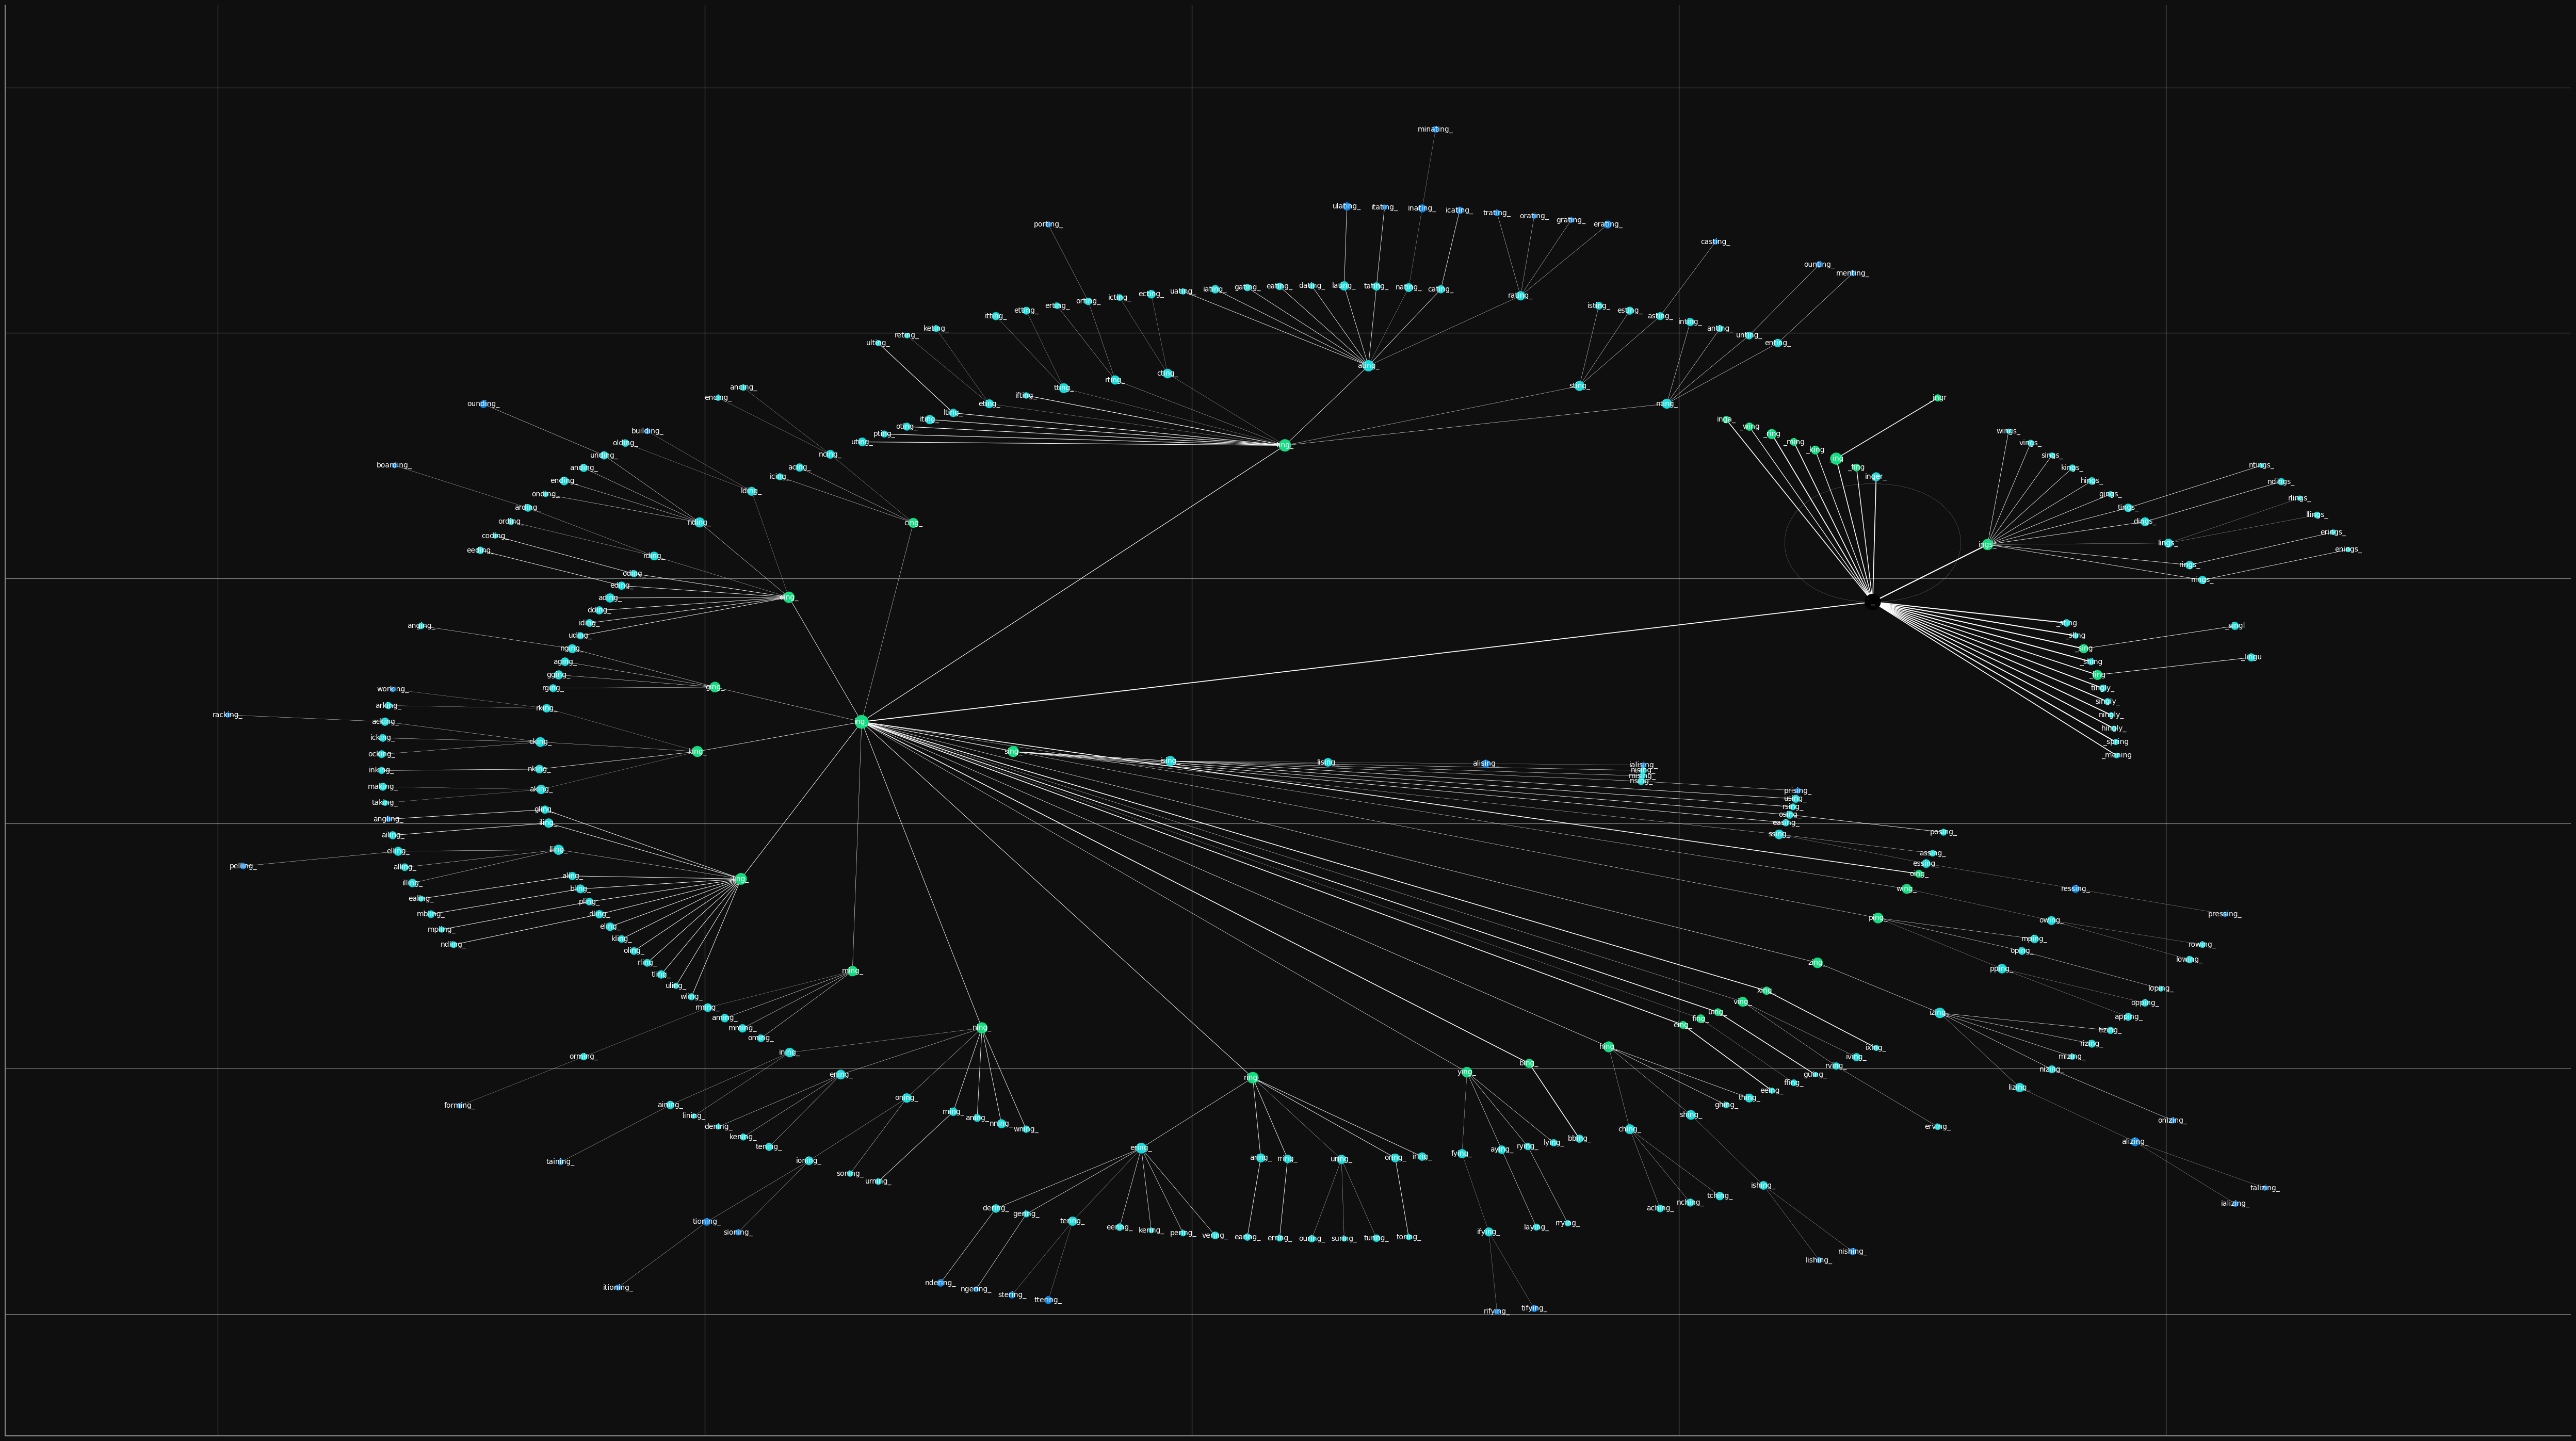

In [2]:

def con_node(x, dbg=False):
    idx = 1
    if x[-1] == '_':
        while idx <= len(x):
            if x[idx:] in nodes:
                y = (x, x[idx:])
                break
            idx += 1
        else:
            return (x, '_', 2)
        if dbg: print(y[0][idx:])
        while idx <= len(y[0]):
            if len(y[0][idx:]) == 1:
                tmp = sfx1
            else:
                tmp = compress(y[0][idx:], t=tf2)
            if y[0][idx-1:][0] in tmp:
                return (*y, tmp[y[0][idx-1:][0]])
            idx += 1
    else:
        while idx <= len(x):
            if x[:-idx] in nodes:
                y = (x, x[:-idx])
                break
            idx += 1
        else:
            return (x, '_', 2)
        if dbg: print(y[0][:-idx])
        while idx <= len(y[0]):
            if idx == 1:
                target = y[0]
            else:
                target = y[0][:-idx+1]
            if len(target) == 1:
                tmp = pfx1
            else:
                tmp = compress(target[:-1], t=tf2)
            if target[-1] in tmp:
                return (*y, tmp[target[-1]])
            idx += 1
    return (x, '_', 2)

cdct = {1: 'k',2: '#08f32a',3: '#08f32a',4: '#14dc81',5: '#14dc81', 6: '#19dbdb',7: '#19dbdb',8: '#0e84e1',9: '#0e84e1'}
#nodes = sorted(tf2, key=lambda x: len(x), reverse=True)
nodes = sorted(search('ing', tf2), key=lambda x: len(x), reverse=True)
nodes.append('_')

edges = []
nsize = []
ewidth = []
eweights = []
ncolors = []

for x in nodes:
    out = con_node(x)
    edges.append((out[0], out[1]))
    eweights.append(out[2])

for x in nodes:
    nsize.append(30*(np.log2(sum(compress(x).values()))-1))

for x in eweights:
    ewidth.append(np.log2(x) / 7.5)

for x in nodes:
    if len(x) in cdct:
        ncolors.append(cdct[len(x)])
    else:
        ncolors.append('#808b96')

atree = nx.Graph()
atree.add_nodes_from(nodes)
atree.add_edges_from(edges)

""" pos = nx.nx_agraph.graphviz_layout(atree, prog="twopi", root='_', args='-Goverlap=scalexy')

fig, ax = plt.subplots(figsize=(50, 28))
nx.draw_networkx(
    atree, 
    pos=pos,
    ax=ax, 
    with_labels=True, 
    width=ewidth, 
    node_size=nsize, 
    node_color=ncolors, 
    edge_color='w', 
    font_color='w',
    font_size=10
) """
